<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Sonion/Sonion_process_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All process in multi weeks

## Prepare data

In [2]:
import datetime
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import iplot
import re

import statistics as st
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import glob
path='/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000/'
#print(path)
all_files1=glob.glob(path + '*.xlsx')
all_files2=glob.glob(path + '*.xlsm')
all_files=all_files1+all_files2
#sort file in directory by reverse:
all_files = sorted(all_files, reverse = False)
print('number of files: ',len(all_files))

number of files:  4


In [4]:
all_files

['/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000/Control Plan data REC 3000 - WK34 - 2020.xlsm',
 '/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000/Control Plan data REC 3000 - WK35 - 2020.xlsm',
 '/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000/Control Plan data REC 3000 - WK36 - 2020.xlsm',
 '/content/drive/My Drive/Data/Sonion/Control plan and stast/Control plan 3000/Control Plan data REC 3000 - WK37 - 2020.xlsm']

In [62]:
#%%time
import xlrd
all_process_week={}
n=0
for path_name in all_files[:2]: # read each excel file
  week_name=path_name[-16:-5]
  xls = xlrd.open_workbook(path_name, on_demand=True)
  sheet_names=xls.sheet_names()
  #print(xls.sheet_names())
  sheet_dict={}
  xls = pd.ExcelFile(path_name) 
  for name in sheet_names: # read each sheet in excel file
    sheet_dict[name] = pd.read_excel(xls, name)
    #sheet_dict[name].to_excel(name+'.xlsx')
  #break
  # Read all process in one week
  sheet_all={} # most important
  sheet_error=[]
  for name_sheet in sheet_names[1:]: # all sheet
    #print(name_sheet)
    sheet=sheet_dict[name_sheet]

    # find begin and end col
    values_col=sheet.iloc[22,:]
    values_col.reset_index(drop=True,inplace=True)
    begin_col=values_col[values_col=='Kích thước\nDimension'].index
    begin_col=begin_col+1
    end_col=values_col[values_col=='MSNV'].index
    #print(begin_col,end_col)
  
    df_dict={} # add all value, USL, LSL, UCL... in sheet
    try:
      for name in sheet.columns[begin_col[0]:end_col[0]]:
        
          df=pd.DataFrame()
          
          #tolerance_dict[sheet[name][22]]=[sheet[name][24],sheet[name][23]]
          df['Date']=sheet[sheet.columns[9]][25:]
          df['Date']=df['Date'].apply(lambda x: x.strftime("%Y %m %d %H"))
          df['Date']=pd.to_datetime(df['Date'])
          #df['Hour']=df['Date'].dt.hour
          df['Value']=sheet[name][25:]
          df['USL']=sheet[name][23] # max
          df['LSL']=sheet[name][24] # min
          df.dropna(subset=['Value'],inplace=True)
          #UCL,LCL,nominal:
          k=3
          df['UCL']=df['Value'].mean() + df['Value'].std()*k
          df['LCL']=df['Value'].mean() - df['Value'].std()*k
          df['Mean']=df['Value'].mean()
          df[df.columns[1:]]=df[df.columns[1:]].astype('float32')
          dim_name=sheet[name][22]
          df_dict[dim_name]=df.reset_index(drop=True)
    except:
      sheet_error.append(name_sheet)
      continue
    sheet_all[name_sheet]=df_dict
  all_process_week[week_name]=sheet_all
  print(week_name,sheet_error)

WK34 - 2020 ['37560', '30740', '37751']
WK35 - 2020 ['30740', '37750-37940_S2', '37751']


In [63]:
all_process_week.keys()

dict_keys(['WK34 - 2020', 'WK35 - 2020'])

In [64]:
all_process_week['WK34 - 2020']['38940']

{'Spout 12-DL_ Connection strength':                  Date      Value  USL   LSL       UCL        LCL       Mean
 0 2020-08-14 16:00:00  56.430000  NaN  50.0  70.73806  48.461941  59.599998
 1 2020-08-14 16:00:00  57.200001  NaN  50.0  70.73806  48.461941  59.599998
 2 2020-08-15 11:00:00  56.279999  NaN  50.0  70.73806  48.461941  59.599998
 3 2020-08-15 11:00:00  55.410000  NaN  50.0  70.73806  48.461941  59.599998
 4 2020-08-15 15:00:00  65.360001  NaN  50.0  70.73806  48.461941  59.599998
 5 2020-08-15 15:00:00  63.759998  NaN  50.0  70.73806  48.461941  59.599998
 6 2020-08-18 11:00:00  63.119999  NaN  50.0  70.73806  48.461941  59.599998
 7 2020-08-18 11:00:00  61.889999  NaN  50.0  70.73806  48.461941  59.599998
 8 2020-08-18 14:00:00  60.279999  NaN  50.0  70.73806  48.461941  59.599998
 9 2020-08-18 14:00:00  56.270000  NaN  50.0  70.73806  48.461941  59.599998,
 'Spout 12-DL_ Vị trí C': Empty DataFrame
 Columns: [Date, Value, USL, LSL, UCL, LCL, Mean]
 Index: [],
 'Spout 12-D

## Concat all week to one base week

In [65]:
print(list(all_process_week.keys())[-1])

WK35 - 2020


In [66]:
base_week={}
base_week=all_process_week[list(all_process_week.keys())[-1]]
base_week.keys() # lấy base là tuần cuối cùng để cập nhật các process mới nhất

dict_keys(['39682', '38682', '30682', '37682', '30665', '30660-37660-38660', '30380-37380-38380', '37670-39670', '37662', '30650-37650 (3500T)', '37650-38655-39650', '37641', '30470-37470', '38546', '39615', '38940', '38594', '37560', '37640-38635', '30674-37674-38674 ', '30672-37672-38672', '30592', '30544-37544-38544-39544', '30538', '30530-37530-39530', '30480-37480-38481', '30370-37370-38370 ', '30750-30940-39750 _S1', '30750-30940-39750 _S2', '37750-37940_S1'])

In [67]:
# concat all process in each weeks based on keys value:
%%time
for week_name in list(all_process_week.keys())[:-1]: # ko tính base week nên trừ 1: 
  other_week=all_process_week[week_name]
  for process_name in other_week.keys(): # dict all process
    for process_name_base in base_week.keys(): # dict all process
        if process_name_base==process_name: # Neu process nam trung voi base week thi concat
          for dim_name in base_week[process_name_base].keys(): # concat dim trong process o cac week khac nhau
             base_week[process_name_base][dim_name]=pd.concat([base_week[process_name_base][dim_name],other_week[process_name_base][dim_name]])
    #print(process_name)


CPU times: user 121 ms, sys: 4.08 ms, total: 125 ms
Wall time: 121 ms


In [68]:
base_week['38940']

{'Spout 12-DL_ Connection strength':                   Date      Value  USL   LSL        UCL        LCL       Mean
 0  2020-08-21 16:00:00  56.279999  NaN  50.0  63.152088  46.821911  54.987000
 1  2020-08-21 16:00:00  54.709999  NaN  50.0  63.152088  46.821911  54.987000
 2  2020-08-24 06:00:00  54.389999  NaN  50.0  63.152088  46.821911  54.987000
 3  2020-08-24 06:00:00  56.720001  NaN  50.0  63.152088  46.821911  54.987000
 4  2020-08-24 15:00:00  52.099998  NaN  50.0  63.152088  46.821911  54.987000
 5  2020-08-24 15:00:00  52.630001  NaN  50.0  63.152088  46.821911  54.987000
 6  2020-08-25 06:00:00  56.279999  NaN  50.0  63.152088  46.821911  54.987000
 7  2020-08-25 06:00:00  54.709999  NaN  50.0  63.152088  46.821911  54.987000
 8  2020-08-25 11:00:00  58.430000  NaN  50.0  63.152088  46.821911  54.987000
 9  2020-08-25 11:00:00  56.740002  NaN  50.0  63.152088  46.821911  54.987000
 10 2020-08-25 16:00:00  60.230000  NaN  50.0  63.152088  46.821911  54.987000
 11 2020-08-25 1

In [69]:
# Check len all dim in base week:
process_len=pd.DataFrame()
process_name_list=[]
dim_name_list=[]
dim_len_list=[]
for process_name in base_week.keys():
  #print(process_name)
  for dim_name in base_week[process_name].keys():
    dim_len=len(base_week[process_name][dim_name])
    #print(dim_name)
    #print()
    process_name_list.append(process_name)
    dim_name_list.append(dim_name)
    dim_len_list.append(dim_len)
    

In [70]:
dim_and_len_df =pd.DataFrame(list(zip(process_name_list,dim_name_list,dim_len_list)),
                             columns=['Process_Name','Dim_name','Len'])
dim_and_len_df.sort_values(by='Len')

,Process_Name,Dim_name,Len
80,38940,Spout JH_ Connection strength,0
81,38940,Spout JH_ Độ lệch vị trí A,0
104,30538,Lực của mối hàn\nWelding spot strength,0
118,30750-30940-39750 _S1,Spout 1-SN_ Connection strength (3300U),0
119,30750-30940-39750 _S1,Spout 1-SN_ Connection strength (not for 3300U),0
...,...,...,...
97,30544-37544-38544-39544,30544-37544-38544 Dim B,524
115,30370-37370-38370,3000 Dim A,563
37,30380-37380-38380,3800 Dim A,678
35,30380-37380-38380,3000 Dim A,900


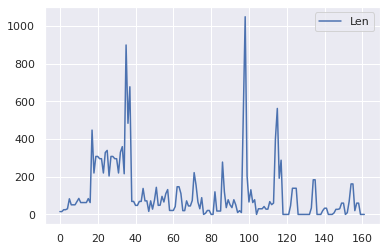

In [71]:
dim_and_len_df.plot()

In [73]:
for i in range(len(dim_and_len_df)):
  if dim_and_len_df.loc[i].Len==0:
    Process_Name=dim_and_len_df.loc[i].Process_Name
    Dim_name=dim_and_len_df.loc[i].Dim_name
    print(Process_Name,Dim_name)
    base_week[Process_Name].pop(Dim_name,None)

38940 Spout 12-DL_ Vị trí C
38940 Spout JH_ Connection strength
38940 Spout JH_ Độ lệch vị trí A
30538 Lực của mối hàn
Welding spot strength
30750-30940-39750 _S1 Spout  1-SN_ Connection strength (3300U)
30750-30940-39750 _S1 Spout  1-SN_ Connection strength (not for 3300U)
30750-30940-39750 _S1 Spout  1-SN_ Độ lệch vị trí A
30750-30940-39750 _S1 Spout  1-SN_ Vị trí B
30750-30940-39750 _S1 Spout 12-DL(dual)_ Connection strength (3300U)
30750-30940-39750 _S1 Spout 12-DL(dual)_ Connection strength (not for 3300U)
30750-30940-39750 _S1 Spout 12-DL(dual)_ Độ lệch vị trí G
30750-30940-39750 _S1 Spout 12-DL(dual)_ Độ lệch vị trí F
30750-30940-39750 _S1 Spout SC_ Connection strength
30750-30940-39750 _S1 Spout SC_ Độ lệch vị trí A
30750-30940-39750 _S1 Spout SC_ Vị trí B
30750-30940-39750 _S2 Spout 12-DL (single)_ Connection strength 
30750-30940-39750 _S2 Spout 12-DL (single_ Độ lệch vị trí A
30750-30940-39750 _S2 Spout 12-DL (single _ Vị trí B
30750-30940-39750 _S2 Spout JH _ Connection str

# Calculate process indicator base on 25 lates subgroup sample

In [52]:
constants={
    2:1.128,
    3:1.693,
    4:2.059,
    5:2.326,
    6:2.534,
    7:2.704,
    8:2.847, 
    9: 2.970,
    10: 3.078,
    11: 3.173,
    12: 3.258,
    13: 3.336,
    14: 3.407,
    15: 3.472,
    16: 3.532,
    17:3.588,
    18:3.640,
    19:3.689,
    20:3.735,
}

In [81]:
def process_performance(data):
  df=data
  #print('dim: ',name)
  n=df.Date.value_counts()[0]
  num_sample=n*25
  df=df[-num_sample:]
  df=df.reset_index(drop=True)
  usl=df.USL[0]
  lsl=df.LSL[0]
  m=df.Value[-n:].mean() # only last day 

  #Ppk
  sigma=st.stdev(df.Value)
  Pp = float(usl - lsl) / (6*sigma)
  Ppu = float(usl - m) / (3*sigma)
  Ppl = float(m - lsl) / (3*sigma)
  Ppk = np.min([Ppu, Ppl])
  #print('Pp:{:.2f} , Ppk: {:.2f}'.format(Pp,Ppk))
  #Cpk
  
  temp=df.groupby('Date').agg({'Value':['min','max']})
  temp['Range']=temp['Value','max']-temp['Value','min']
  Range=temp['Range'].mean()

  if n <= 20:
    sigma_within = Range/constants[n]
  else:
    sigma_within = Range/constants[20]

  Cp = float(usl - lsl) / (6*sigma_within)
  Cpu = float(usl - m) / (3*sigma_within)
  Cpl = float(m - lsl) / (3*sigma_within)
  Cpk = np.min([Cpu, Cpl])
  #print('Cp:{:.2f} , Cpk:{:.2f}'.format(Cp,Cpk))
  Cp=round(Cp,2)
  Cpk=round(Cpk,2)
  Pp=round(Pp,2)
  Ppk=round(Ppk,2)
  return Cp,Cpk,Pp,Ppk
 

In [96]:
process_indicator_dict={}
process_indicator_df=pd.DataFrame(columns=['Process_name','Dim_name','Cp','Pp','Cpk','Ppk'])
#process_indicator_df.columns=['Dim','Cp','Cpk','Pb','Ppk']
i=0
for process_name in list(base_week.keys()):
  print(process_name)
  df_dict=base_week[process_name]
  for dim_name in list(df_dict.keys()): #also group
    print(dim_name)
    df=df_dict[dim_name]
    #print(dim_name)
    #try: # object column cannot be calculated process indicator (OK, Not OK...) How to remove object colum in the beginning ?
    Cp,Cpk,Pp,Ppk=process_performance(df) 
    #except: continue
    process_indicator_dict[dim_name]=[Cp,Pp,Cpk,Ppk]
    process_indicator_df.loc[i]=process_name,dim_name,Cp, Pp, Cpk, Ppk
    i+=1

process_indicator_df=process_indicator_df.sort_values(by='Cpk').reset_index(drop=True)

#conver process indicator dict to list name:
name_list=[]
for name in process_indicator_dict.keys():
  dim_name=name + ' Cp: ' + str(process_indicator_dict[name][0]) + ' Pp: '+ \
  str(process_indicator_dict[name][1]) +' Cpk: ' \
  + str(process_indicator_dict[name][2]) +' Ppk: '+ str(process_indicator_dict[name][3]) 
  name_list.append(dim_name)

39682
Chiều rộng Dim E
Chiều dài Dim C
Cung hint Dim I
Cung J Dim J
Offset Dim M
38682
Hinge Dim F
Chiều dài Dim B
Chiều rộng Dim A
L.Tâm Dim N
Offset Dim M
Ba vớ trên membrane
30682
Hinge Dim F
Chiều dài Dim B
Chiều rộng Dim A
L.Tâm Dim N
Offset Dim M
Ba vớ trên membrane
37682
Offset Dim M
Ba vớ trên membrane
30665
30660 Độ sâu foil 
30660 Offset Dim M
37660 _3500T Độ sâu foil 
37660 _3500T Offset Dim M
37660  Độ sâu foil 
37660 Offset Dim M
38660  Độ sâu foil 
38660 Offset Dim M
30660-37660-38660
30660 Độ sâu foil 
30660 Offset Dim M
37660 _3500T Độ sâu foil 
37660 _3500T Offset Dim M
37660  Độ sâu foil 
37660 Offset Dim M
38660  Độ sâu foil 
38660 Offset Dim M
30380-37380-38380
3000 Dim A
3700 Dim A
3800 Dim A
37670-39670
3500T Đường kính lỗ bù (dim B)
3500T Vị trí của lỗ bù (dim A)
3900T Đường kính lỗ bù (dim B)
3900T Vị trí của lỗ bù (dim A)
37662
Kích thước lỗ drive pin (dim B)
Độ lệch tâm của lỗ drive pin (dim C)
Offset of membrane ( Dim D)
30650-37650 (3500T)
30650 Dim E
30650 

### Debug

In [59]:
process_name

'38940'

In [60]:
base_week[process_name]

In [ ]:

process_indicator_dict={}
process_indicator_df=pd.DataFrame(columns=['Dim','Cp','Pp','Cpk','Ppk'])
#process_indicator_df.columns=['Dim','Cp','Cpk','Pb','Ppk']
i=0
for process_name in list(base_week.keys()):
  print(process_name)
  df_dict=base_week[process_name]
  for dim_name in list(df_dict.keys()): #also group
    print(dim_name)
    df=df_dict[dim_name]
    #print(dim_name)
    #try: # object column cannot be calculated process indicator (OK, Not OK...) How to remove object colum in the beginning ?
    #Cp,Cpk,Pp,Ppk=process_performance(df) 

    #print('dim: ',name)
    n=df.Date.value_counts()[0]
    num_sample=n*25
    df=df[-num_sample:]
    df=df.reset_index(drop=True)
    usl=df.USL[0]
    lsl=df.LSL[0]
    m=df.Value[-n:].mean() # only last day 

    #Ppk
    sigma=st.stdev(df.Value)
    Pp = float(usl - lsl) / (6*sigma)
    Ppu = float(usl - m) / (3*sigma)
    Ppl = float(m - lsl) / (3*sigma)
    Ppk = np.min([Ppu, Ppl])
    #print('Pp:{:.2f} , Ppk: {:.2f}'.format(Pp,Ppk))
    #Cpk

    temp=df.groupby('Date').agg({'Value':['min','max']})
    temp['Range']=temp['Value','max']-temp['Value','min']
    Range=temp['Range'].mean()

    if n <= 20:
      sigma_within = Range/constants[n]
    else:
      sigma_within = Range/constants[20]

    Cp = float(usl - lsl) / (6*sigma_within)
    Cpu = float(usl - m) / (3*sigma_within)
    Cpl = float(m - lsl) / (3*sigma_within)
    Cpk = np.min([Cpu, Cpl])
    #print('Cp:{:.2f} , Cpk:{:.2f}'.format(Cp,Cpk))
    Cp=str(round(Cp,2))
    Cpk=str(round(Cpk,2))
    Pp=str(round(Pp,2))
    Ppk=str(round(Ppk,2))

    #except: continue
    process_indicator_dict[dim_name]=[Cp,Pp,Cpk,Ppk]
    process_indicator_df.loc[i]=dim_name,Cp, Pp, Cpk, Ppk
    i+=1


39682
Chiều rộng Dim E
Chiều dài Dim C
Cung hint Dim I
Cung J Dim J
Offset Dim M
38682
Hinge Dim F
Chiều dài Dim B
Chiều rộng Dim A
L.Tâm Dim N
Offset Dim M
Ba vớ trên membrane
30682
Hinge Dim F
Chiều dài Dim B
Chiều rộng Dim A
L.Tâm Dim N
Offset Dim M
Ba vớ trên membrane
37682
Offset Dim M
Ba vớ trên membrane
30665
30660 Độ sâu foil 
30660 Offset Dim M
37660 _3500T Độ sâu foil 
37660 _3500T Offset Dim M
37660  Độ sâu foil 
37660 Offset Dim M
38660  Độ sâu foil 
38660 Offset Dim M
30660-37660-38660
30660 Độ sâu foil 
30660 Offset Dim M
37660 _3500T Độ sâu foil 
37660 _3500T Offset Dim M
37660  Độ sâu foil 
37660 Offset Dim M
38660  Độ sâu foil 
38660 Offset Dim M
30380-37380-38380
3000 Dim A
3700 Dim A
3800 Dim A
37670-39670
3500T Đường kính lỗ bù (dim B)
3500T Vị trí của lỗ bù (dim A)
3900T Đường kính lỗ bù (dim B)
3900T Vị trí của lỗ bù (dim A)
37662
Kích thước lỗ drive pin (dim B)
Độ lệch tâm của lỗ drive pin (dim C)
Offset of membrane ( Dim D)
30650-37650 (3500T)
30650 Dim E
30650 

IndexError: ignored

### End debug

In [89]:
process_indicator_df

,Process_name,Dim_name,Cp,Pp,Cpk,Ppk
0,30470-37470,37470 (3500K) Chiều dài drive pin sau khi cắt_...,0.55,0.53,0.07,0.06
1,30682,Chiều rộng Dim A,0.88,0.74,0.12,0.10
2,30380-37380-38380,3800 Dim A,0.16,0.05,0.16,0.05
3,30660-37660-38660,38660 Độ sâu foil,0.93,0.55,0.17,0.10
4,30650-37650 (3500T),37650 (3500T) Dim E,1.75,1.05,0.18,0.11
...,...,...,...,...,...,...
132,30750-30940-39750 _S2,Spout 12SL (on 3100) _ Connection strength,NaN,NaN,NaN,NaN
133,37750-37940_S1,Spout EL _ Connection strength,NaN,NaN,NaN,NaN
134,37750-37940_S1,Spout DL (dual)_Connection strength (3700U),NaN,NaN,NaN,NaN
135,37750-37940_S1,Spout DL (dual)_Connection strength (not for 3...,NaN,NaN,NaN,NaN


In [90]:
process_indicator_df.dtypes

Process_name     object
Dim_name         object
Cp              float64
Pp              float64
Cpk             float64
Ppk             float64
dtype: object

In [92]:
def hightlight_price(row):
    ret = ["" for _ in row.index]
    if row.Cpk < limit or row.Ppk < limit:
      ret[row.index.get_loc("Process_name")] = "background-color: yellow"
      ret[row.index.get_loc("Dim_name")] = "background-color: yellow"
    if row.Cpk < limit:    
      ret[row.index.get_loc("Cpk")] = "background-color: yellow"
    if row.Ppk < limit:  
      ret[row.index.get_loc("Ppk")] = "background-color: yellow"
    return ret

limit = 1.33  # sigma: 4, Yield: 99.99%   
process_indicator_df.style.apply(hightlight_price, axis=1)

,Process_name,Dim_name,Cp,Pp,Cpk,Ppk
0,30470-37470,37470 (3500K) Chiều dài drive pin sau khi cắt_Dim B,0.550000,0.530000,0.070000,0.060000
1,30682,Chiều rộng Dim A,0.880000,0.740000,0.120000,0.100000
2,30380-37380-38380,3800 Dim A,0.160000,0.050000,0.160000,0.050000
3,30660-37660-38660,38660 Độ sâu foil,0.930000,0.550000,0.170000,0.100000
4,30650-37650 (3500T),37650 (3500T) Dim E,1.750000,1.050000,0.180000,0.110000
5,30672-37672-38672,30672 Dim H,1.190000,0.850000,0.200000,0.140000
6,39682,Chiều rộng Dim E,0.970000,0.570000,0.260000,0.150000
7,39615,Chiều dài rộng lõi Al (dim B),0.880000,0.860000,0.280000,0.270000
8,39682,Chiều dài Dim C,0.670000,0.690000,0.290000,0.300000
9,30665,37660 _3500T Độ sâu foil,0.960000,0.720000,0.310000,0.230000


nan value: missing USL or LSL

## Line chart

### Try better method

In [97]:
for process_name in list(base_week.keys())[:3]:
  df_dict=base_week[process_name] # process name
  i=1
  #Layout
  fig = make_subplots(          # Dim name
      rows=len(df_dict), cols=1,
      #shared_xaxes=True, # share same axis
      #vertical_spacing=0.05, # adjust spacing between charts
      #column_widths=[0.8, 0.2],
      subplot_titles=(name_list)
  )
  for name in list(df_dict.keys()): #also group
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    df=df.reset_index(drop=True)
    # Draw control chart
    df_group=df.groupby('Date').mean()
    #df=df.set_index('Date')
    #if start_date != '':
    #  df=df[start_date:end_date]
    #Control chart 1 
    fig.append_trace(go.Scatter(
                            x=df_group.index, y=df_group['Value'],mode='lines+markers',
                            name='mean ' +name , 
                            line=dict( color='#4280F5')
                            ),row=i, col=1)
    #USL, LSL
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    #fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['UCL'],name='UCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['LCL'],name='LCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df_group.index, y=df_group['Mean'],name='Mean '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    i=i+1
  

  fig.update_layout(height=200*len(df_dict), width=1200, title_text='Process: '+process_name)
  #fig update each process (contain a lot of dim inside)
  fig.show()
 

### End better method

Original (stabel)

In [ ]:
for sheet_name in list(base_week.keys())[:3]:
  df_dict=base_week[sheet_name] # process

  i=1
  #Layout
  fig = make_subplots(              # all dim in each process
      rows=len(df_dict), cols=1,
      #shared_xaxes=True, # share same axis
      #vertical_spacing=0.05, # adjust spacing between charts
      #column_widths=[0.8, 0.2],
      subplot_titles=(list(df_dict.keys()))
  )
  for name in df_dict.keys(): #also group
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    df=df.reset_index(drop=True)
    try:
      process_performance(df)
    except: 
      print('error calculate process performance')
    # Draw control chart
    df=df.groupby('Date').mean()
    #df=df.set_index('Date')
    #if start_date != '':
    #  df=df[start_date:end_date]
    #Control chart 1 
    fig.append_trace(go.Scatter(
                            x=df.index, y=df['Value'],mode='lines+markers',
                            name='mean ' + name,line=dict( color='#4280F5')
                            ),row=i, col=1
                  )
    #USL, LSL
    fig.append_trace(go.Scatter(x=df.index, y=df['USL'],name='USL '+name, line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733'),mode='lines'),row=i, col=1)
    #fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    fig.append_trace(go.Scatter(x=df.index, y=df['UCL'],name='UCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['LCL'],name='LCL '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['Mean'],name='Mean '+name, line=dict( color='#33C2FF'),mode='lines'),row=i, col=1)
    i=i+1

  fig.update_layout(height=200*len(df_dict), width=1200, title_text='process '+sheet_name)
  fig.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Box plot chart

In [ ]:
for sheet_name in base_week.keys():
  df_dict=base_week[sheet_name]
    
  i=1
  #Layout
  fig = make_subplots(
      rows=len(df_dict), cols=1,
      #shared_xaxes=True, # share same axis
      vertical_spacing=0.05, # adjust spacing between charts
      #column_widths=[0.8, 0.2],
      subplot_titles=(list(df_dict.keys()))
  )
  for name in df_dict.keys(): #also group
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    df=df.set_index('Date')
    #Control chart 1 
    fig.append_trace(go.Box(
                            x=df.index, y=df['Value'],
                            name='mean ' + name, line=dict( color='#4280F5')
                            ),row=i, col=1
                  )
    #USL, LSL
    fig.append_trace(go.Scatter(x=df.index, y=df['USL'],name='USL '+name, line=dict( color='#FF5733')),row=i, col=1)
    fig.append_trace(go.Scatter(x=df.index, y=df['LSL'],name='LSL '+name,line=dict( color='#FF5733')),row=i, col=1)
    #fig.append_trace(go.Scatter(x=df['Datef'], y=df['Nominal'],name='Nominal '+name,line=dict( color='#FF5733')),row=i, col=1)
    # UCL, LCL
    i=i+1
    
  fig.update_layout(height=200*len(df_dict), width=1200, title_text=sheet_name)
  #fig.show()

## Py manufacturing

In [ ]:
for sheet_name in base_week.keys():
  print('process: ',sheet_name)
  df_dict=base_week[sheet_name]
  for name in df_dict.keys(): #also group
    print('dim: ',name)
    df=df_dict[name].copy()
    df=df.sort_values(by=['Date'])
    for a in df.columns[1:]:
      df[a] = df[a].round(decimals=3)
    try:
      #mn.control_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])
      mn.ppk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])
      mn.cpk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0],
              subgroup_size=df.Date.value_counts()[0])
    except:
      continue
   

## Calculate Cp/CpK/Ppk from base week (last week)

In [ ]:
constants={
    2:1.128,
    3:1.693,
    4:2.059,
    5:2.326,
    6:2.534,
    7:2.704,
    8:2.847, 
    9: 2.970,
    10: 3.078,
    11: 3.173,
    12: 3.258,
    13: 3.336,
    14: 3.407,
    15: 3.472,
    16: 3.532,
    17:3.588,
    18:3.640,
    19:3.689,
    20:3.735,
}

In [ ]:
import statistics as st
process_indicator={}
for process_name in base_week.keys():
  try:
    #print(process_name)
    process_dict=base_week[process_name]
    for dim in process_dict.keys():
      #print(dim)
      df=process_dict[dim]
      usl=df.USL[0]
      lsl=df.LSL[0]
      m=df.Mean[0]

      #Ppk
      sigma=st.stdev(df.Value)
      Pp = float(usl - lsl) / (6*sigma)
      Ppu = float(usl - m) / (3*sigma)
      Ppl = float(m - lsl) / (3*sigma)
      Ppk = np.min([Ppu, Ppl])
      #print('Pp',Pp)
      #print('Ppk',Ppk)

      #Cpk
      n=df.Date.value_counts()[0]
      temp=df.groupby('Date').agg({'Value':['min','max']})
      temp['R']=temp['Value','max']-temp['Value','min']
      R=temp['R'].mean()

      if n <= 20:
        sigma_within = R/constants[n]
      else:
        sigma_within = R/constants[20]
      
      Cp = float(usl - lsl) / (6*sigma_within)
      Cpu = float(usl - m) / (3*sigma_within)
      Cpl = float(m - lsl) / (3*sigma_within)
      Cpk = np.min([Cpu, Cpl])
      #print('Cp',Cp)
      #print('Cpk',Cpk)
  except:
    print('error:')
    print('process_name: ',process_name)
    print('dim: ',dim)
    continue

error:
process_name:  37670-39670
dim:  3500T Đường kính lỗ bù (dim B)
error:
process_name:  30470-37470
dim:  30470 Chiều dài drive pin sau khi cắt_Dim B 
error:
process_name:  38940
dim:  Spout 12-DL_ Vị trí C
error:
process_name:  30538
dim:  Lực của mối hàn
Welding spot strength
error:
process_name:  30750-30940-39750 _S1
dim:  Spout  1-SN_ Connection strength (3300U)
error:
process_name:  30750-30940-39750 _S2
dim:  Spout 12-DL (single)_ Connection strength 
error:
process_name:  37750-37940_S1
dim:  Spout  EL _ Vị trí C_11s
error:
process_name:  37750-37940_S2
dim:  Spout  1-SN (3700U) _ Connection strength


In [ ]:
import statistics as st
process_name='38682'
process_dict=base_week[process_name]
process_indicator={}
for dim in process_dict.keys():
  print(dim)
  df=process_dict[dim]
  # PPk"
  sigma=st.stdev(df.Value)
  usl=df.USL[0]
  lsl=df.LSL[0]
  m=df.Mean[0]
  Pp = float(usl - lsl) / (6*sigma)
  Ppu = float(usl - m) / (3*sigma)
  Ppl = float(m - lsl) / (3*sigma)
  Ppk = np.min([Ppu, Ppl])
  print('Pp',Pp)
  print('Ppk',Ppk)
  # CPK"
 

Hinge Dim F
Pp 0.8979230733571717
Ppk 0.7243247128588255
Chiều dài Dim B
Pp 0.611506076738254
Ppk 0.36690656193393173
Chiều rộng Dim A
Pp 0.5632059313075698
Ppk 0.5181419371853514
L.Tâm Dim N
Pp 1.4544298377882001
Ppk 0.8959287618724691
Offset Dim M
Pp nan
Ppk nan
Ba vớ trên membrane
Pp nan
Ppk nan


In [ ]:
 process_dict.keys()

dict_keys(['Hinge Dim F', 'Chiều dài Dim B', 'Chiều rộng Dim A', 'L.Tâm Dim N', 'Offset Dim M', 'Ba vớ trên membrane'])

In [ ]:
df=process_dict['Hinge Dim F']
df

,Date,Value,USL,LSL,UCL,LCL,Mean
0,2020-09-04 16:00:00,0.231,0.25,0.21,0.25614,0.211593,0.233867
1,2020-09-04 16:00:00,0.231,0.25,0.21,0.25614,0.211593,0.233867
2,2020-09-04 16:00:00,0.228,0.25,0.21,0.25614,0.211593,0.233867
3,2020-09-05 08:00:00,0.241,0.25,0.21,0.25614,0.211593,0.233867
4,2020-09-05 08:00:00,0.237,0.25,0.21,0.25614,0.211593,0.233867
5,2020-09-05 08:00:00,0.246,0.25,0.21,0.25614,0.211593,0.233867
6,2020-09-07 09:00:00,0.239,0.25,0.21,0.25614,0.211593,0.233867
7,2020-09-07 09:00:00,0.217,0.25,0.21,0.25614,0.211593,0.233867
8,2020-09-07 09:00:00,0.242,0.25,0.21,0.25614,0.211593,0.233867
9,2020-09-08 10:00:00,0.232,0.25,0.21,0.25614,0.211593,0.233867


3

In [ ]:
usl=df.USL[0]
lsl=df.LSL[0]
m=df.Mean[0]

In [ ]:
temp=df.groupby('Date').agg({'Value':['min','max']})
temp

Value       
                       min    max
Date                             
2020-09-04 16:00:00  0.228  0.231
2020-09-05 08:00:00  0.237  0.246
2020-09-07 09:00:00  0.217  0.242
2020-09-08 10:00:00  0.230  0.240
2020-09-08 16:00:00  0.225  0.235

In [ ]:
temp.columns

MultiIndex([('Value', 'min'),
            ('Value', 'max')],
           )

In [ ]:
temp['Value','min']

Date
2020-09-04 16:00:00    0.228
2020-09-05 08:00:00    0.237
2020-09-07 09:00:00    0.217
2020-09-08 10:00:00    0.230
2020-09-08 16:00:00    0.225
Name: (Value, min), dtype: float32

In [ ]:
temp['R']=temp['Value','max']-temp['Value','min']

In [ ]:
temp

Value             R
                       min    max       
Date                                    
2020-09-04 16:00:00  0.228  0.231  0.003
2020-09-05 08:00:00  0.237  0.246  0.009
2020-09-07 09:00:00  0.217  0.242  0.025
2020-09-08 10:00:00  0.230  0.240  0.010
2020-09-08 16:00:00  0.225  0.235  0.010

In [ ]:
R=temp['R'].mean()
R

0.011400002054870129

In [ ]:
constants={
    2:1.128,
    3:1.693,
    4:2.059,
    5:2.326,
    6:2.534,
    7:2.704,
    8:2.847, 
    9: 2.970,
    10: 3.078,
    11: 3.173,
    12: 3.258,
    13: 3.336,
    14: 3.407,
    15: 3.472
}

In [ ]:
n=df.Date.value_counts()[0]
sigma_within=R/constants[n]
sigma_within

0.006733610191890211

In [ ]:
usl=df.USL[0]
lsl=df.LSL[0]
m=df.Mean[0]
Cp = float(usl - lsl) / (6*sigma_within)
Cpu = float(usl - m) / (3*sigma_within)
Cpl = float(m - lsl) / (3*sigma_within)
Cpk = np.min([Cpu, Cpl])
print('Cp',Cp)
print('Cpk',Cpk)

sigma=st.stdev(df.Value)
Pp = float(usl - lsl) / (6*sigma)
Ppu = float(usl - m) / (3*sigma)
Ppl = float(m - lsl) / (3*sigma)
Ppk = np.min([Ppu, Ppl])
print('Pp',Pp)
print('Ppk',Ppk)

Cp 0.9900584633556088
Cpk 0.7986472710878285
Pp 0.8979230733571717
Ppk 0.7243247128588255


In [ ]:
#!pip install manufacturing

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



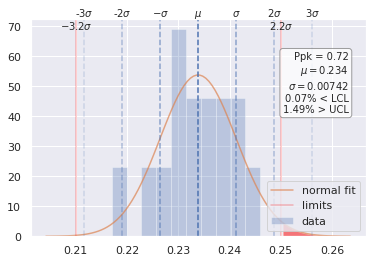

In [ ]:
import manufacturing as mn
mn.ppk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])

shapiro test indicates that the distribution is NOT normal
skewtest is not valid with less than 8 samples; 3 samples were given.
the data set is most likely not normally distributed
skewtest is not valid with less than 8 samples; 3 samples were given.
the zupper and zlower limits are strongly imbalanced, indicating that the process is off-center with reference to the limits
skewtest is not valid with less than 8 samples; 3 samples were given.
skewtest is not valid with less than 8 samples; 3 samples were given.
the zupper and zlower limits are strongly imbalanced, indicating that the process is off-center with reference to the limits
skewtest is not valid with less than 8 samples; 3 samples were given.
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=15



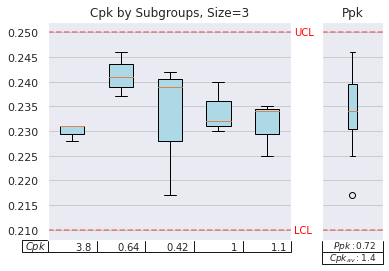

In [ ]:
mn.cpk_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0],
            subgroup_size=3)

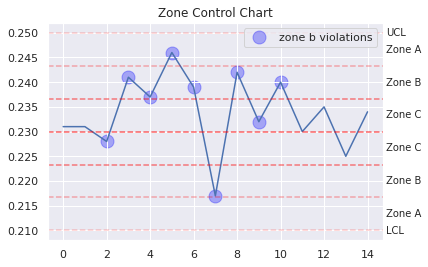

In [ ]:
mn.control_plot(df.Value, upper_control_limit=df.USL[0], lower_control_limit=df.LSL[0])
# Khong group df ở đây